# Exogenous data management

Exogenous data can be loaded in **EOReader** along the product, as for the DEM.

There are several things you need to know to handle EXO properly.

In [1]:
# Imports
import os

from eoreader.reader import Reader
from eoreader.bands import DEM
from eoreader.keywords import DEM_KW, EXO_KW

In [2]:
# Create logger
import logging
from sertit import logs

logger = logging.getLogger("eoreader")
logs.init_logger(logger)

In [3]:
# Open the product
path = os.path.join("/media/gsalgues/ESPACE/rasters/SENTINEL2B_20241227-104904-377_L2A_T31TCJ_C_V4-0")
prod = Reader().open(path)

In [4]:
# EXO data paths
exo_folder = os.path.join("/media/gsalgues/ESPACE/EXO")
s2w = os.path.join(exo_folder, "s2w-globalmask-31TCJ.tif")
dtm = os.path.join("/media/gsalgues/ESPACE/DEM", "output.vrt")
import rasterio
with rasterio.open(str(s2w)) as exo_ds:
    info = {i: dtype for i, dtype in zip(exo_ds.indexes, exo_ds.dtypes)}
    print(info)

    #print(rasterio.dtypes.can_cast_dtype([9.999],exo_ds.dtypes))

{1: 'uint8'}


Then you may load specific layer from the EXO folder using the `load` or `stack` function.

To do this, you need to provide the `EXO_KW`.
The expected value is a dictionnary containing the target name of the layer as key, and the path as sub-attribute.

In the case where the file provide as path is multi-layer, must specify a band number to load.

In [5]:
loaded_bands = prod.load(
    ['GREEN'], 
    **{
        EXO_KW: {'s2w_mask': {'bandnumber' : 1, 'path' : s2w, 'resampler' : 'nearest'}},     
    }
)
# display the xarray.Dataset
loaded_bands

2025-11-04 17:34:24,878 - [DEBUG] - Loading bands ['GREEN']
2025-11-04 17:34:24,881 - [DEBUG] - Read GREEN
2025-11-04 17:34:25,374 - [DEBUG] - Manage nodata for band GREEN
2025-11-04 17:34:25,382 - [DEBUG] - Converting GREEN to reflectance
2025-11-04 17:34:44,064 - [INFO] - Loading bands {'s2w_mask': {'bandnumber': 1, 'path': '/media/gsalgues/ESPACE/EXO/s2w-globalmask-31TCJ.tif', 'resampler': 'nearest'}}
2025-11-04 17:34:44,065 - [DEBUG] - EXO data info: s2w_mask ; {'bandnumber': 1, 'path': '/media/gsalgues/ESPACE/EXO/s2w-globalmask-31TCJ.tif', 'resampler': 'nearest'}
2025-11-04 17:34:44,067 - [DEBUG] - Warping EXO for 20241227T104904_S2THEIA_T31TCJ_L2A
2025-11-04 17:34:44,067 - [DEBUG] - Using EXO: /media/gsalgues/ESPACE/EXO/s2w-globalmask-31TCJ.tif
2025-11-04 17:34:44,094 - [DEBUG] - Collocating EXO bands
2025-11-04 17:34:44,095 - [DEBUG] - Append EXO bands at the end of current band_dict


<xarray.Dataset> Size: 965MB
Dimensions:                  (x: 10980, y: 10980, band: 1)
Coordinates:
  * x                        (x) float64 88kB 3e+05 3e+05 ... 4.098e+05
  * y                        (y) float64 88kB 4.9e+06 4.9e+06 ... 4.79e+06
    spatial_ref              int64 8B 0
  * band                     (band) int64 8B 1
Data variables:
    SpectralBandNames.GREEN  (band, y, x) float32 482MB 0.0 0.0 ... 0.0739
    s2w_mask                 (band, y, x) float32 482MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    long_name:         GREEN s2w_mask
    constellation:     Sentinel-2 Theia
    constellation_id:  S2_THEIA
    product_path:      /media/gsalgues/ESPACE/rasters/SENTINEL2B_20241227-104...
    product_name:      SENTINEL2B_20241227-104904-377_L2A_T31TCJ_C_V4-0
    product_filename:  SENTINEL2B_20241227-104904-377_L2A_T31TCJ_C_V4-0
    instrument:        MSI
    product_type:      MSIL2A
    acquisition_date:  20241227T104904
    condensed_name:    20241227T104904_S2THEIA_T31TCJ_L2A
    orbit_direction:   DESCENDING
    cloud_cover:       21.0

You can then access the loaded layer as you would do for any band of the product.

In [6]:
loaded_bands['s2w_mask']

<xarray.DataArray 's2w_mask' (band: 1, y: 10980, x: 10980)> Size: 482MB
dask.array<where, shape=(1, 10980, 10980), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
    spatial_ref  int64 8B 0
  * band         (band) int64 8B 1
Attributes:
    path:              /tmp/tmplpv3l6va/tmp_20241227T104904_S2THEIA_T31TCJ_L2...
    long_name:         s2w_mask
    constellation:     Sentinel-2 Theia
    constellation_id:  S2_THEIA
    product_path:      /media/gsalgues/ESPACE/rasters/SENTINEL2B_20241227-104...
    product_name:      SENTINEL2B_20241227-104904-377_L2A_T31TCJ_C_V4-0
    product_filename:  SENTINEL2B_20241227-104904-377_L2A_T31TCJ_C_V4-0
    instrument:        MSI
    product_type:      MSIL2A
    acquisition_date:  20241227T104904
    condensed_name:    20241227T104904_S2THEIA_T31TCJ_L2A
    orbit_direction:   DESCENDING

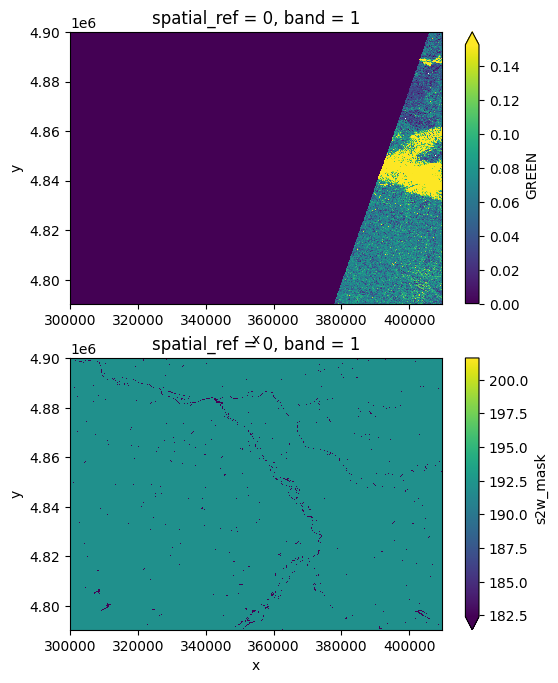

In [7]:

import matplotlib.pyplot as plt

# Plot EXO bands
ncols = len(loaded_bands)
plt.figure(figsize=(6, 6 * ncols))
i = 0
for key in loaded_bands.keys():
    axes = plt.subplot(3, 1, i+1)
    loaded_bands[key][0, ::10, ::10].plot.imshow(robust=True)
    i += 1